## Imports and Helper functions

In [1]:
import seaborn as sns
import matplotlib
import matplotlib.colors
import numpy as np
import mediapy as media
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import PIL
import io

import matplotlib.patches

from IPython.display import HTML as html_print

In [2]:
def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
  if num_objects is None:
    num_objects = np.max(seg)  # assume consecutive numbering
  num_objects += 1  # background
  if palette is None:
    palette = [bg_color] + sns.color_palette('hls', num_objects-1)

  seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
  for i in range(num_objects):
    seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
  return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
  cmap = np.array(colormap.colors)
  if sqrt:
    d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
  else:
    d = np.round(depth[..., 0] // 256).astype(np.uint8)
  return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
  height, width = vec.shape[:2]
  scaling = 50. / (height**2 + width**2)**0.5
  direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
  norm = np.linalg.norm(vec, axis=-1)
  if flow_mag_range is None:
    flow_mag_range = norm.min(), norm.max()
  magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
  if white_bg == True:
    value = np.ones_like(direction)
    hsv = np.stack([direction, magnitude, saturation], axis=-1)
  else:
    saturation = np.ones_like(direction)
    hsv = np.stack([direction, saturation , magnitude], axis=-1)
  rgb = matplotlib.colors.hsv_to_rgb(hsv)
  return rgb

def plot_bboxes(sample, palette=None, linewidth=1):
  resolution = sample["video"].shape[-3:-1]

  bboxes = sample["instances"]["bboxes"]
  bbox_frames = sample["instances"]["bbox_frames"]
  num_objects = bboxes.shape[0]
  if palette is None:
      palette = sns.color_palette('hls', num_objects)
  images = []
  for t, rgb in enumerate(sample["video"]):
    fig, ax = plt.subplots(figsize=(resolution[0]/100, resolution[1]/100), dpi=132.5)
    ax.axis("off")
    ax.imshow(rgb)
    for k in range(num_objects):
      if t in bbox_frames[k]:
        idx = np.nonzero(bbox_frames[k] == t)[0][0]

        miny, minx, maxy, maxx = bboxes[k][idx]
        miny = max(1, miny*resolution[0])
        minx = max(1, minx*resolution[1])
        maxy = min(resolution[0]-1, maxy*resolution[0])
        maxx = min(resolution[1]-1, maxx*resolution[1])
        rect = matplotlib.patches.Rectangle([minx, miny], maxx-minx, maxy-miny,
                                            linewidth=linewidth, edgecolor=palette[k],
                                            facecolor='none')
        ax.add_patch(rect)


    for k in range(num_objects):
      x, y = sample["instances"]["image_positions"][k, t] * resolution
      if np.all(1 < y < resolution[0]-1) and np.all(1 < x < resolution[1]-1):
        ax.scatter(x, y, marker="X", s=5, color=palette[k])
    buf = io.BytesIO()
    fig.savefig(buf, format = "png", bbox_inches = 'tight', pad_inches = 0, dpi=132.5)
    plt.close(fig)
    buf.seek(0)
    img = PIL.Image.open(buf)
    images.append(np.array(img)[..., :3])
  return images

def getsize(arr): 
  if isinstance(arr, np.ndarray):
    return arr.nbytes
  elif isinstance(arr, dict):
    return sum([getsize(v) for v in arr.values()])
  elif isinstance(arr, list):
    return sum([getsize(v) for v in arr])
  else:
    return sys.getsizeof(arr)

def print_instance_ids(sample, ds_info, palette=None):
  if palette is None:
    palette = sns.color_palette('hls', sample["metadata"]["num_instances"])
  out = ''
  if "asset_id" in sample["instances"]:
    ids = [s.decode() for s in sample["instances"]["asset_id"]]
  else:
    labels = []
    if "size_label" in sample["instances"]:
      labels.append([ds_info.features["instances"]["size_label"].names[k]
                       for k in sample["instances"]["size_label"]])
    if "color_label" in sample["instances"]:
      labels.append([ds_info.features["instances"]["color_label"].names[k]
                       for k in sample["instances"]["color_label"]])
    labels.append([ds_info.features["instances"]["material_label"].names[k]
                       for k in sample["instances"]["material_label"]])
    labels.append([ds_info.features["instances"]["shape_label"].names[k]
                   for k in sample["instances"]["shape_label"]])
    ids = [" ".join(x) for x in zip(*labels)]

  for i, (color, asset_id) in enumerate(zip(palette, ids)):
    color_hex = '#%02x%02x%02x' % tuple(int(x*255) for x in color)
    out += f'{i}. <b><text style=color:{color_hex}>{asset_id}</text></b><br/>'
    
  return html_print(out)

## Load the Dataset

In [5]:
ds, ds_info = tfds.load("movi_e", data_dir="gs://kubric-public/tfds", with_info=True)
train_iter = iter(tfds.as_numpy(ds["train"]))


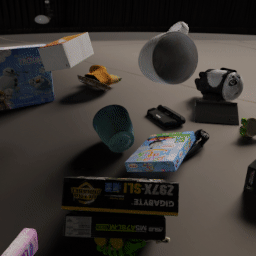
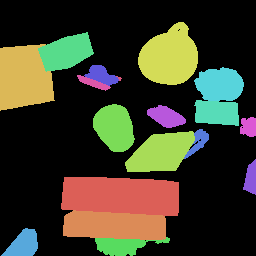
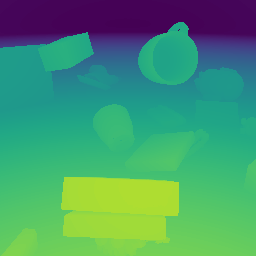
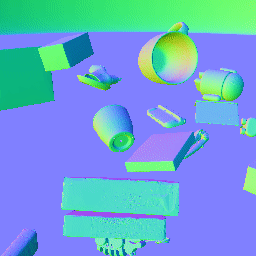
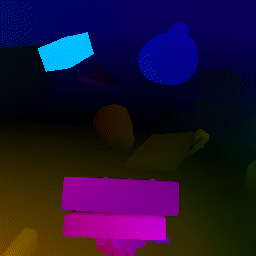
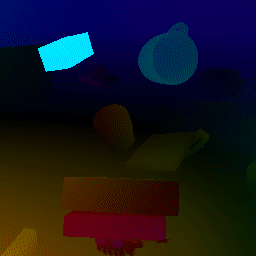
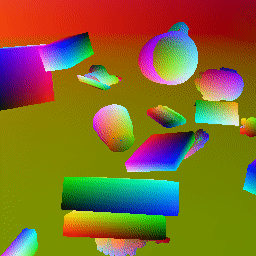
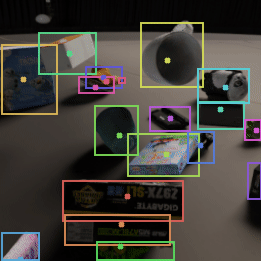

In [11]:
example = next(train_iter)
minv, maxv = example["metadata"]["forward_flow_range"]
forward_flow = example["forward_flow"] / 65535 * (maxv - minv) + minv

minv, maxv = example["metadata"]["backward_flow_range"]
backward_flow = example["backward_flow"] / 65535 * (maxv - minv) + minv

minv, maxv = example["metadata"]["depth_range"]
depth = example["depth"] / 65535 * (maxv - minv) + minv

media.show_videos({"rgb": example["video"], 
                   "segmentation": [segmentation_to_rgb(s, num_objects=example["metadata"]["num_instances"])
                                    for s in example["segmentations"]],
                   "depth": depth_to_rgb(example["depth"], sqrt=True),
                   "normal": example["normal"],
                   "forward_flow": flow_to_rgb(forward_flow, white_bg=False),
                   "backward_flow": flow_to_rgb(backward_flow, white_bg=False),
                   "object_coordinates": example["object_coordinates"], 
                   "bboxes/center_of_mass": plot_bboxes(example),
                   },
                fps=12,
                columns=4,
                codec="gif",
)
print_instance_ids(example, ds_info)